In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
from PIL import Image
from IPython.display import display


### Setting up the trajectory ###
This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [2]:
pdb='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise3/data/ubq.pdb'
trajectory='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise3/data/ubq.desres.s500.dcd'
outdir='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise3/out'
    
# print("outdir:",outdir)
# print("pdb:",pdb)
# print("trjaectory:",trajectory)

In [3]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

All things we need to analyse are in this paper he gave us. No trick questions. 

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=[residue for residue in trj.topology.residues]
resname=[residue.name for residue in trj.topology.residues]
resindex=[residue.index for residue in trj.topology.residues]
res_num=[residue.resSeq  for residue in trj.topology.residues]

# print("** SYSTEM INFO **\n")
# print("Number of atoms: %d\n" % trj.n_atoms)
# print("Number of residues: %d\n" % len(set(nres)))
# print("Number of frames: %d\n" % trj.n_frames)
# print("Starting frame: %d\n" % first_frame)
# print("Last frame: %d\n" % last_frame)
# print("sequence: %s\n" % sequence)
# print("residue names: %s\n" % resname)
# print("residue number: %s\n" % res_num)
# print("residue index: %s\n" % resindex)


In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)

### DSSP ###

In [6]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

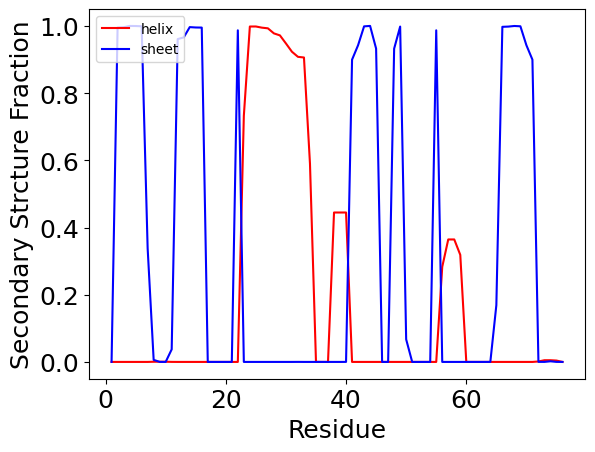

In [8]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


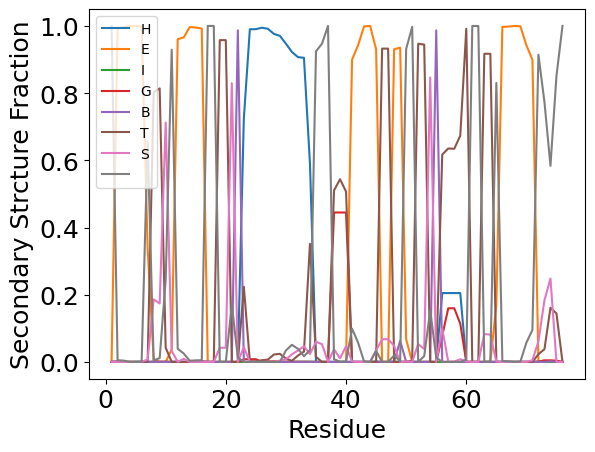

In [9]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [10]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


### PHI / PSI / CHI ###

In [123]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [124]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [125]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
    plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
    plt.xlabel('$\phi$', size=18)
    plt.ylabel('$\psi$', size=18)
    plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
    plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
    plt.tick_params(labelsize=18)
    plt.show()
    return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




### RMSD ###
over the whole course of the trajectory, to make sure the force field isn't just melting your protein lol 

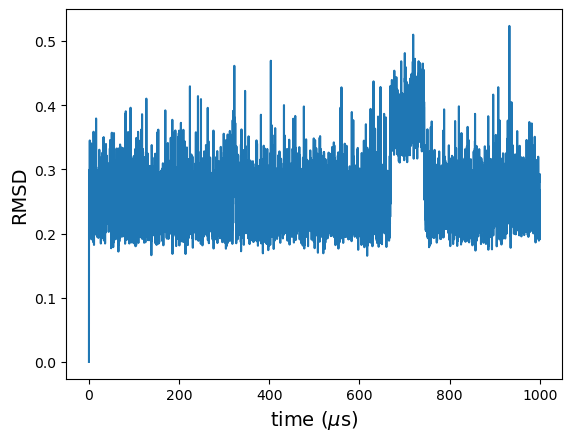

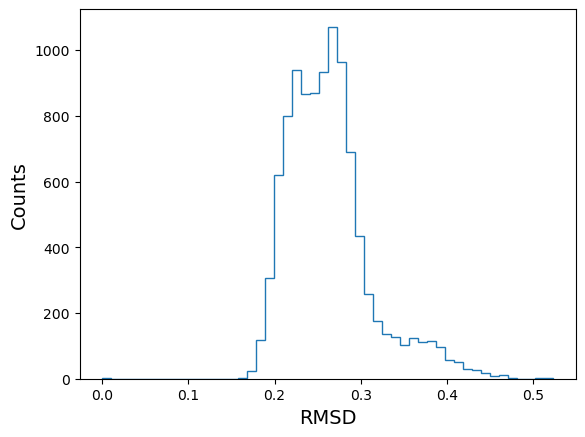

In [32]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

### Radius of gyration ###
calc center of mass of the protein, and then get RMSD of the distance of every residue to the COM 

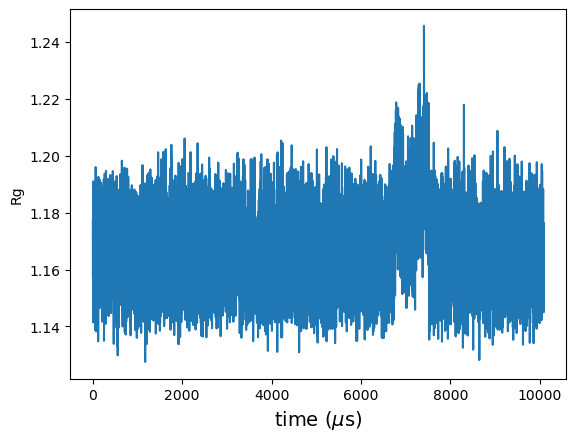

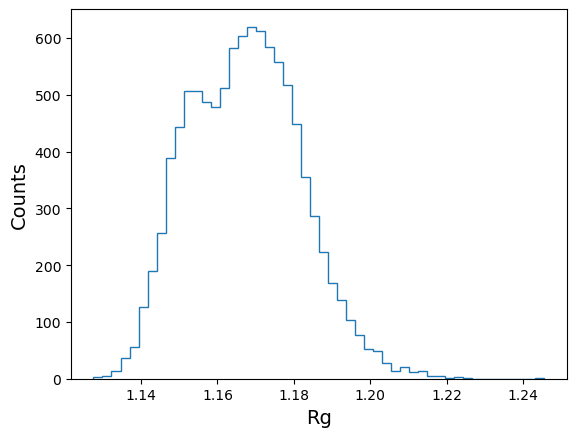

In [33]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(np.arange(n_frames),rg)
plt.ylabel('Rg')
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14)
plt.xlabel('Rg',size=14)
plt.show()

### Hbonds ###
Searches for every Hbond donor and acceptor, and will check to see if these pairs ever meet the criteria of being an HBond

In [14]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
# for hbond in hbonds:
#     print(label(hbond))

# Where hbond has the indices of the atoms, formatted like this: 
# [donor_idx, h_idx, acceptor_idx]
# printed out in order of which is the most populated in the trajectory 
    

In [15]:
# for hbond in hbonds:
#     donor = top.atom(hbond[0])
#     acc = top.atom(hbond[2])
#     print(hbond,donor,acc)

[  55   56 1044] PHE4-N SER65-O


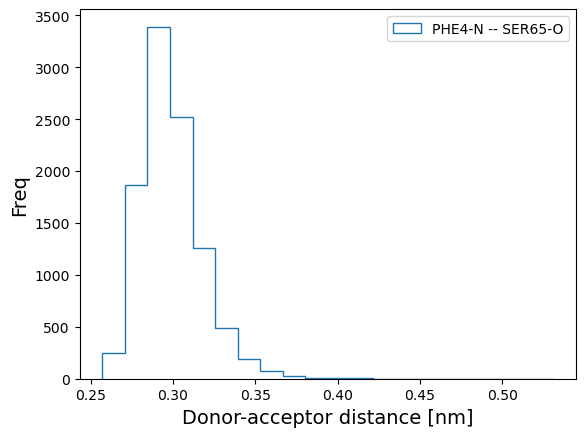

In [18]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14)
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

Okay, let's attempt something fun: 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

In [67]:
# so we want to make a n_res by n_res plot of hbonds that form in between residues. 
# grabbing this first : 
hbond_dist = md.compute_distances(trj, hbonds[:, 1:])
hbond_idx = np.where(hbond_dist<.4, 1, 0) # shape (n_frames, n_hbonds)

# Ok, now time to grab who's who in the hbonds... 

trj.top.atom(268).residue.index

15

In [92]:
hbond_residues = []
for pair in hbonds[:, 1:]: 
    res_0 = trj.top.atom(pair[0]).residue.index 
    res_1 = trj.top.atom(pair[1]).residue.index 
    hbond_residues.append([res_0, res_1])

In [95]:
# array with shape (114, 2) with the 2 res idx of each hbond 
hbond_res = np.array(hbond_residues)

In [116]:
# Let's do this as a list comprehension task bc i really can't think of a smarter way to do it right now. 
hbond_contacts_ = np.empty((trj.n_frames, trj.n_residues, trj.n_residues))
for fr in range(trj.n_frames): 
    hbond_frame = hbond_idx[fr]

    hbond_bool_idx = np.where(hbond_frame ==1)[0]

    for i in hbond_bool_idx:
        res1 = hbond_res[i][0]
        res2 = hbond_res[i][1]
        hbond_contacts_[fr][res1][res2] = 1


In [163]:
hbcon= hbond_contacts_.mean(0)

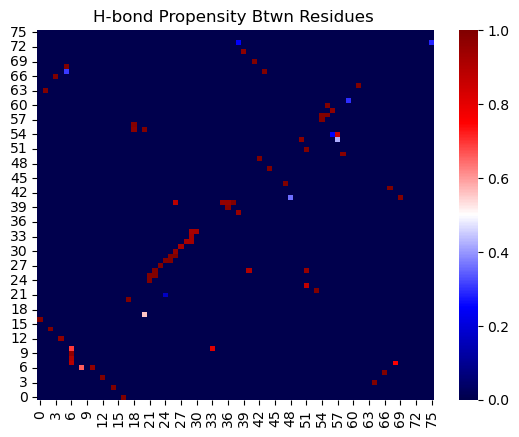

In [172]:
mask = np.zeros_like(hbcon)
zeros=np.where((hbcon>0.20) & (hbcon<0.70))
mask[zeros] = True
ax = sns.heatmap(hbcon, vmin=0, vmax=1,cmap='seismic')
ax.invert_yaxis()
#ax.grid(which='both', alpha=0.5)
# ax.set_xticks(range(2, trj.n_residues-1))
# ax.set_yticks(range(2, trj.n_residues-1))
# ax.set_xticklabels(np.array(sequence)[2:trj.n_residues-1],rotation=45)
# ax.set_yticklabels(np.array(sequence)[2:trj.n_residues-1],rotation=45)
plt.title("H-bond Propensity Btwn Residues ")
plt.show()

So this is kind of interesting... its a little hard to see, but you can see the lightest squares are those that are always populated throughout the whole trajectory. The darker ones (purple ish) on the other hand seem to be transiently populated, suggesting that the hbonds are broken somewhere in the simulation. I'm seeing this for resid 38 (which we identify later), along with a few in the 50s range as well as the 70s range. 

### ***We're going to run a Principle Component Analysis (PCA)*** ###

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [11]:
import sklearn
from sklearn.decomposition import PCA

# coordinates are not invariant :(
# but we're using the coordinates here 
pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(10088, 2)


In [9]:
# always takes the biggest ones! SVD is always sorted 
pca1.singular_values_

array([331.6648 , 245.90674], dtype=float32)

In [8]:
dir(pca1)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_features_out',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_para

In [11]:
# should be n_atoms*3 (our dimensions)
pca1.components_.shape

(2, 3693)

intraresidues distances!  standard way of avoiding this problem of mapping a variant thing onto PCA, as these distances are translationally and rotationally invariant. In this case, the dimensions our data would be (n_res(n_res-1))/2 (factors out symmetry and then the same to the same)

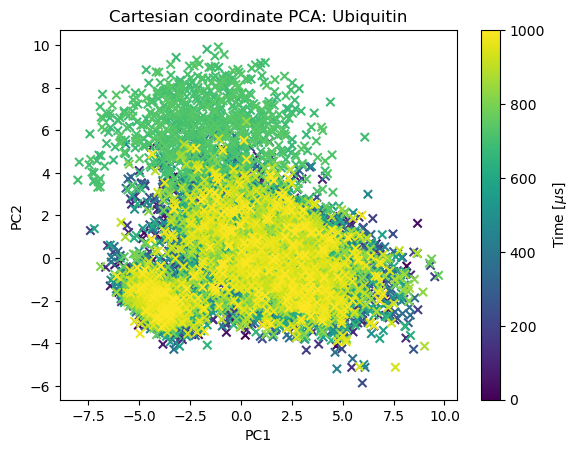

In [24]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

# a point for every frame (every structure)
# now, our data is in 3*n_atoms dimensions 

From our knowledge that the transiently conformation change is around 650-750 microseconds, we can see that this blob in the upper left here should be the PCA of our state when the helix breaks and pops out. Now, we can map things onto this PCA to see how things change when this structural change occurs. 

other things to map 

-   num of helical residues 

-   num of hbonds 

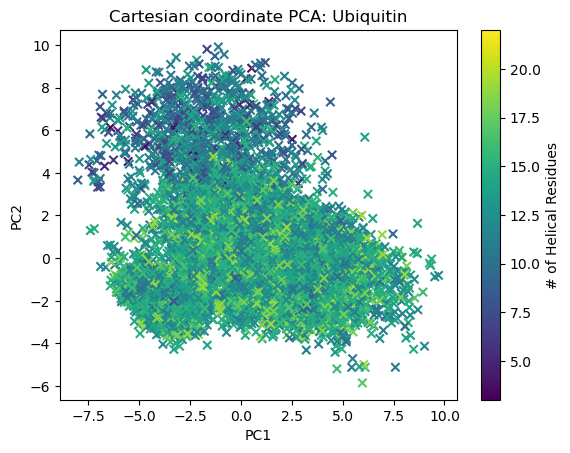

In [12]:
# Mapping # of helical residues / frame using the DSSP 
dssp_helix = np.where(dssp == 'H', 1, 0).sum(1)

plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=dssp_helix)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('# of Helical Residues')

So now we are starting to see this transiently populated state in this upper left blob that has less helical residues! Let's jump in and see which frames exactly are giving us this blob and what they look like. 

In [39]:
pc1 = reduced_cartesian[:, 0]
pc2 = reduced_cartesian[:,1]

In [42]:
frame_idx = np.where((pc1 >-7) & (pc1 <2.5) & (pc2 >4) & (pc2 <9) )
frame_idx

(array([ 105,  160,  301,  371,  386,  472,  481,  617,  640,  813,  885,
         931, 1204, 1543, 1549, 1551, 1696, 1757, 1765, 1865, 1874, 1933,
        1935, 2010, 2088, 2103, 2104, 2112, 2118, 2259, 2291, 2302, 2391,
        2392, 2424, 2701, 2785, 2876, 3015, 3042, 3053, 3054, 3059, 3082,
        3180, 3218, 3230, 3252, 3253, 3262, 3299, 3375, 3412, 3542, 3715,
        3748, 3784, 3788, 3909, 3922, 3953, 3956, 3989, 3990, 4140, 4143,
        4147, 4164, 4166, 4359, 4363, 4421, 4517, 4615, 4620, 4690, 4806,
        4808, 4809, 4811, 4879, 4883, 4933, 4951, 5027, 5051, 5161, 5167,
        5255, 5439, 5539, 5649, 6115, 6227, 6347, 6421, 6535, 6587, 6620,
        6663, 6743, 6744, 6746, 6747, 6749, 6750, 6751, 6752, 6753, 6755,
        6756, 6757, 6759, 6760, 6761, 6764, 6766, 6767, 6768, 6769, 6770,
        6771, 6772, 6773, 6774, 6776, 6777, 6778, 6779, 6780, 6781, 6782,
        6783, 6784, 6785, 6787, 6788, 6790, 6791, 6792, 6793, 6794, 6795,
        6798, 6799, 6800, 6803, 6804, 

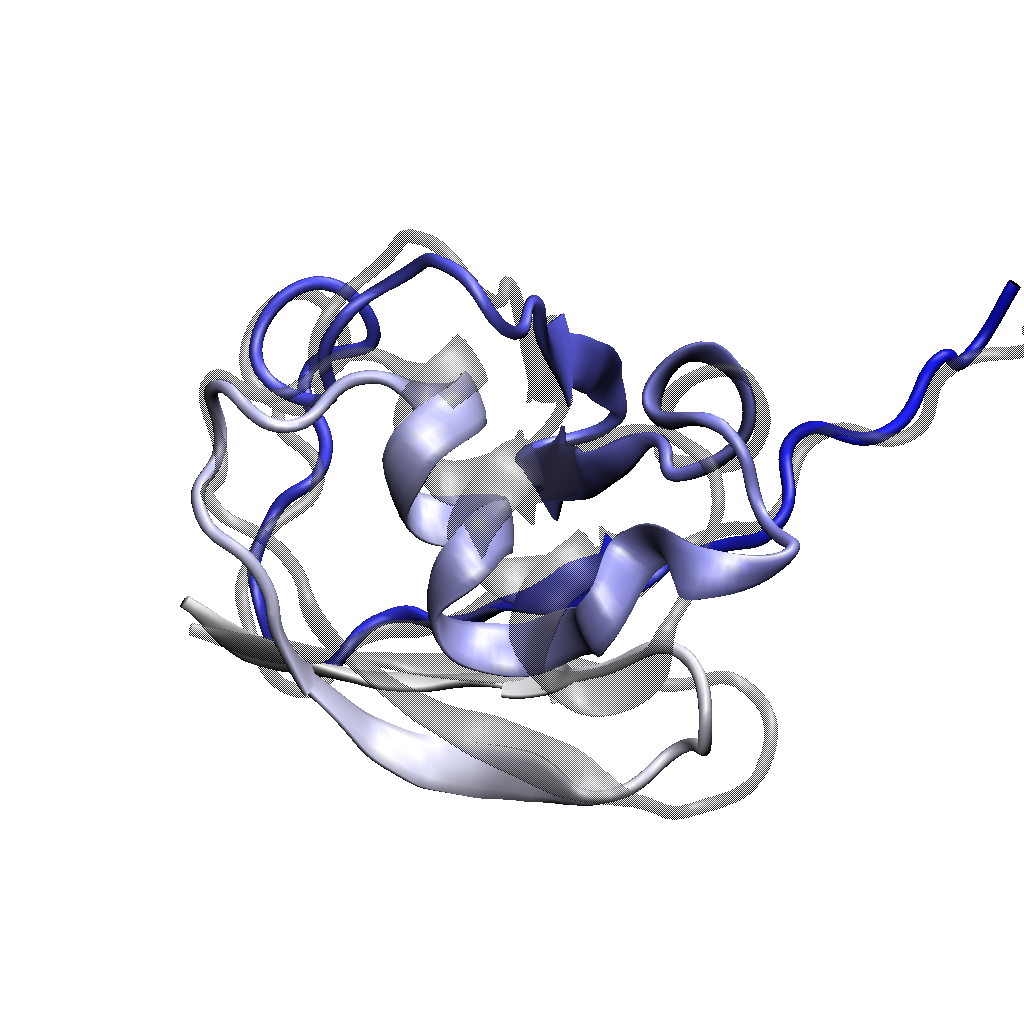

In [43]:
img2 = Image.open(f'{outdir}/fr_6800.png') 
display(img2)

Yup!! That helix has popped out alright. Now, we know for sure in that PC space that there is less helical content and that its definitely associated with this structural change we see in this trajectory.

In [49]:
# Now, looking at the # of hbonds for a given frame 

# We'll take the hbonds that are populated, use md.compute_distances to compute distance between 
# the acceptor atom and the h atom, and implement a cutoff of 4 angstroms. 
# Then, we'll see how many remain in each frame! 

hbond_dist = md.compute_distances(trj, hbonds[:, 1:])

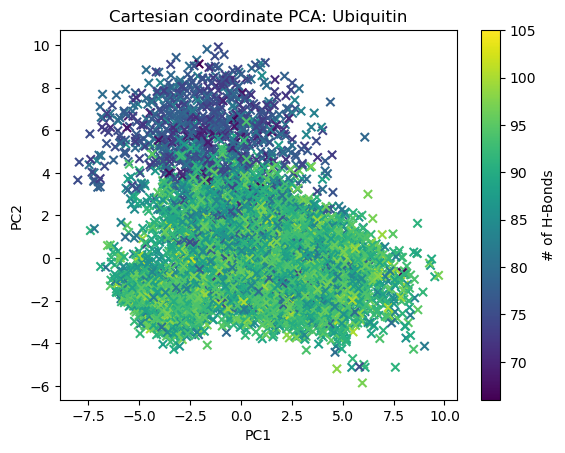

In [51]:
cutoff_hbond = np.where(hbond_dist<0.4, 1, 0).sum(1)

plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=cutoff_hbond)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('# of H-Bonds')

Damn, nice! Looks like the number of hbonds significantly decreases in our state populated from 650-750 microseconds. Let's take a look at one of these hbonds in VMD to see it be destroyed!!

In [56]:
# finding hbonds that were there at frame 1, but then weren't there for frame 6800 (that we identified before)
np.where((hbond_dist[6800]>.4) & (hbond_dist[1]<.4))

(array([ 9, 10, 12, 13, 14, 15, 16, 17, 18, 23, 37, 49, 50, 51, 52, 53, 54,
        55, 58, 59, 62, 64, 77]),)

In [59]:
hbonds[54]

array([555, 556, 488])

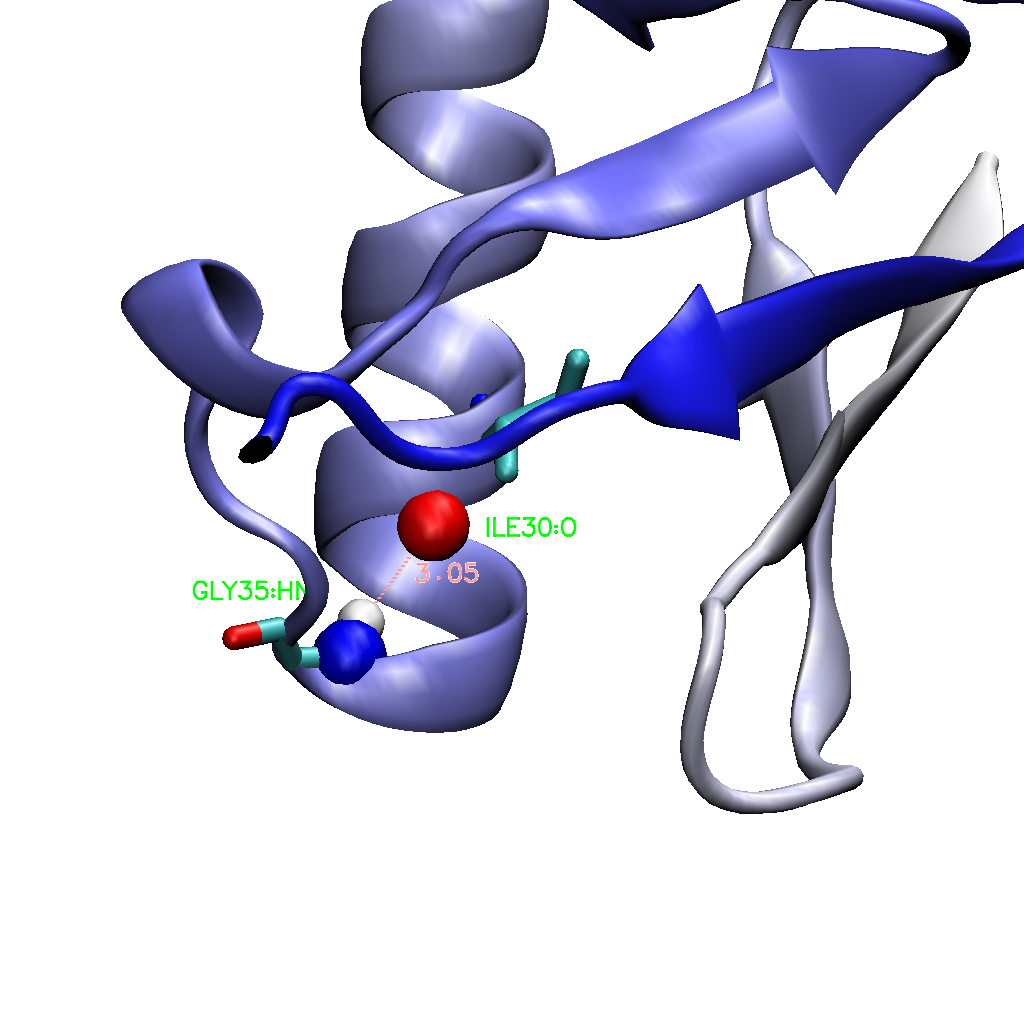

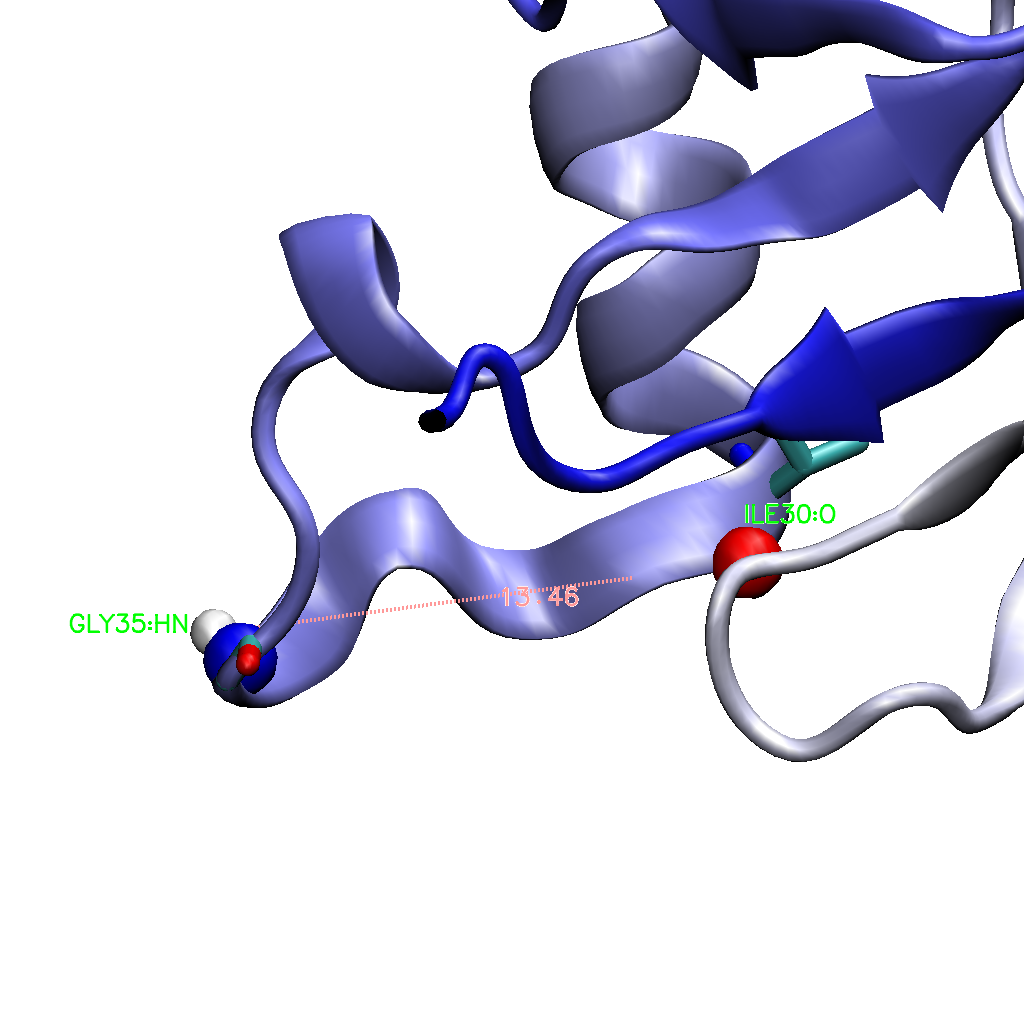

In [60]:
# Looking at the distance between atom 556 and atom 488 (resid 30 & 35) at frame 1 vs frame 6800 in VMD: 
img1 = Image.open(f'{outdir}/fr_6800_hbond1.png') 
img2 = Image.open(f'{outdir}/fr_6800_hbond2.png') 
display(img1)
display(img2)

Check it out! Our cute little hbond in this helix was completely obliterated in frame 6800, where the distance went from 3.05 A to then 13.46 A. That's insane, and exactly what we were seeing in the PCA mapping we did of the total # of hbonds in the system // frame! 

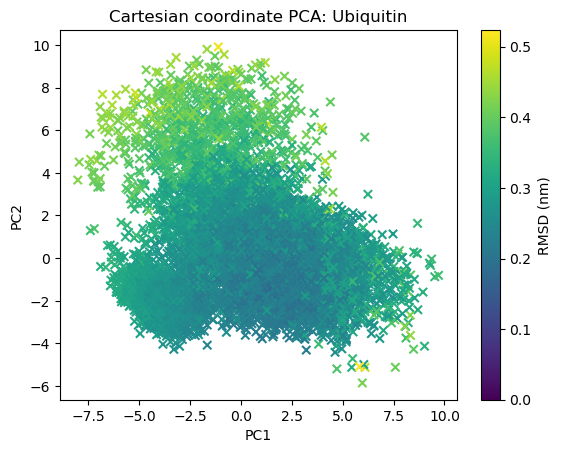

In [34]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')


The RMSD also seems to become larger!

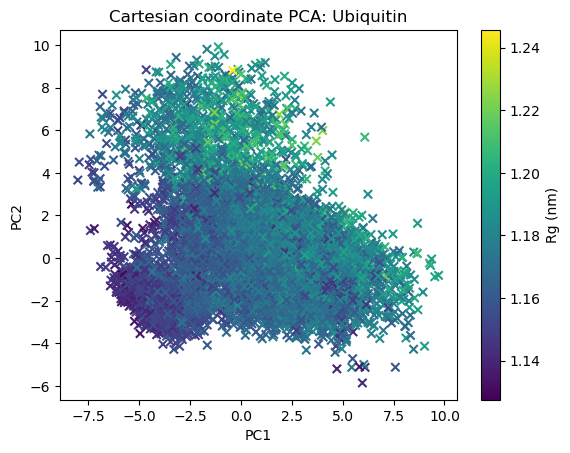

In [36]:
# Now checking out the radius of gyration: 
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')


And the radius of gyration as well seems to become larger as we populate this 650-750 microsecond state!

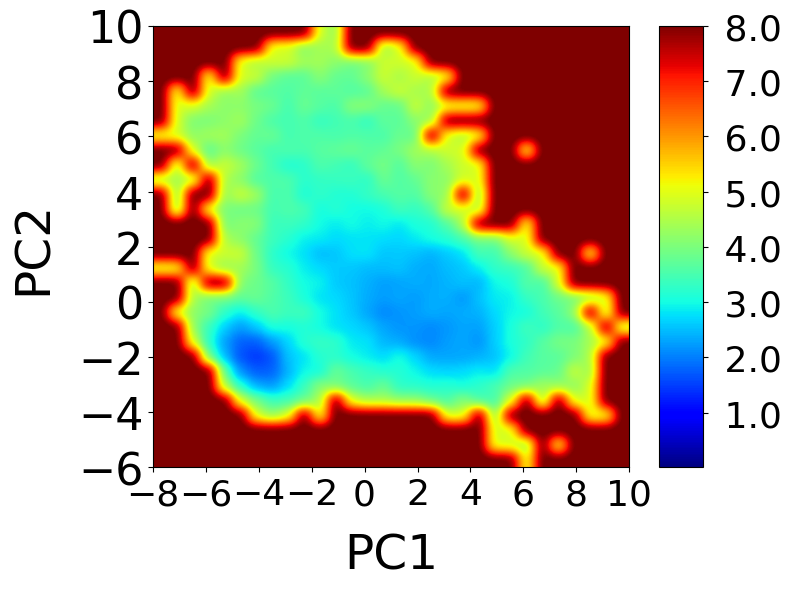

In [26]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges
# boltzman! p = e^-E/kb*T
# p ? 2d histogram
# just solving for E 


PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

look at frames in certain basins we see above by using np.where on PC1 and PC2, visualize them with rep snapshots, and say what's different? missing hbond, these are in different rotamers, this is what's happening

### Visualizing the two different states ###
(with the major conformational change at 650 microseconds)

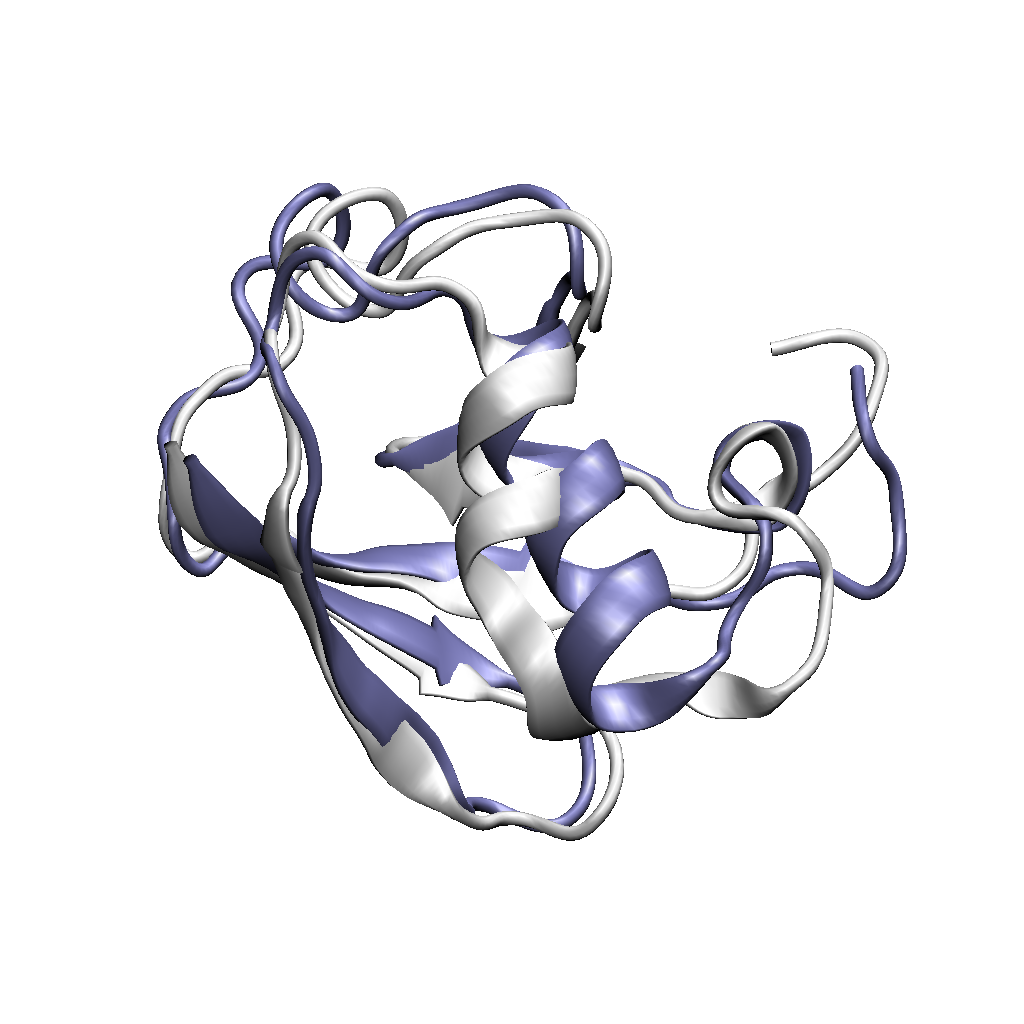

In [75]:
img2 = Image.open(f'{outdir}/50vs7005.png') 
display(img2)

Here's our major conformational change! In iceblue is our protein at 50 microseconds, whereas in white we see our protein at 700.5 microseconds. You can see that the biggest shift is in the helix, where it goes from being wound up to a more "uncoiled", extended conformation (almost like it pops out!). This occurs ~650-750 microseconds in the simulation. You can see that the first two coils of the helix sort of remain intact while the rest of it uncoils. 

### Auto-Correlation ###

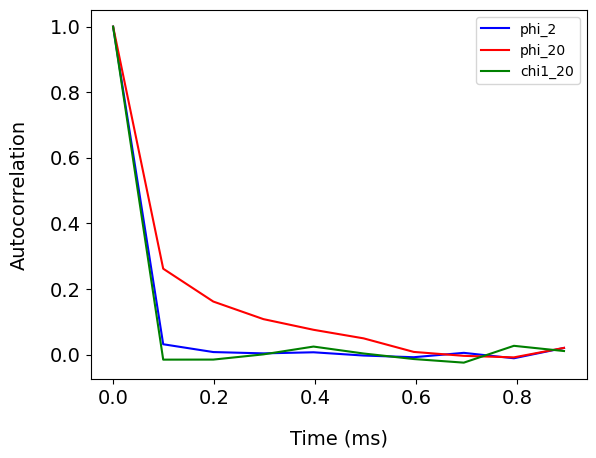

In [126]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
# auto correlation: how long it takes to lose our memory of this thing 
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time (ms)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [58]:
# Creating a function to return a list of residues that have correlation times longer than 0.4 microseconds. 
# the threshol I'll use for still "correlated" will be 0.05? 
def return_corr_residues(n_res=76, thres_time=0.5, threshold_corr=0.1): 
    """ Need pre-defined phi / psi dict, where n_res is an int, thres_time is in microseconds, 
     and the threshold_corr is the minumum correlation we need to say we are decorrelated :) """
    # defining this corr residue dictionary 
    corr_res = {}
    total_time = 1 
    steps = 10
    threshold_idx = int(((thres_time/total_time)*steps)-1)
    param = ['phi', 'psi', 'chi1', 'chi2']

    # Going through each different angle 
    for par in param: 
        corr_res[par] = []

        # Going through each different residue and calculating autocorrleation 
        for res in range(n_res+1): 

            # checking if the residue is in our dictionary (for things like chi2)
            if res in dihedral_dict[par].keys(): 
                # calculating the autocor
                acf = autocorr1(dihedral_dict[par][res],range(steps))

            # if our values at our threshold time are above our threshold, add them to the correlated residue dictionaries 
                if acf[threshold_idx] > threshold_corr: 
                        corr_res[par].append(res)
    
    return corr_res

In [59]:
corr_res_dict=return_corr_residues()

Text(0.5, 1.0, 'psi angles')

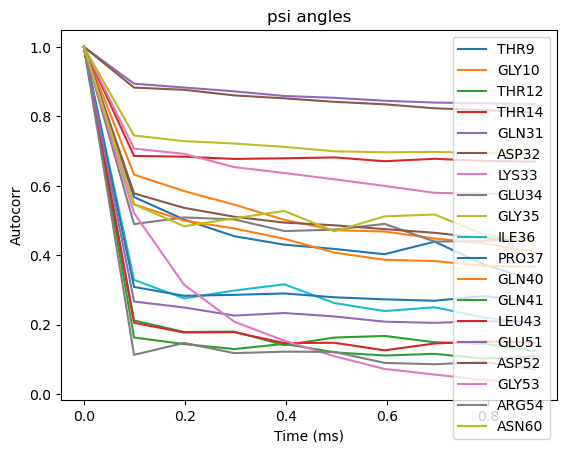

In [66]:
# Great! Now let's visualize one of them with a plot to make sure these have longer correlation times :) 
# Let's look at psi.... 

for res in corr_res_dict['psi']: 
    acf = autocorr1(dihedral_dict['psi'][res],range(10))
    plt.plot(time[range(10)], acf, label=f'{sequence[res]}')
plt.legend()
plt.ylabel('Autocorr')
plt.xlabel('Time (ms)')
plt.title("psi angles")

Damn! we're definitely getting some dihedrals here that stay super duper correlated throughout the trajectory!! That's so wild. Let's maybe take a look at GLN31 and ASP32 to get a better picture of what's going on: 

so, first, where the helix is just chilling stably 

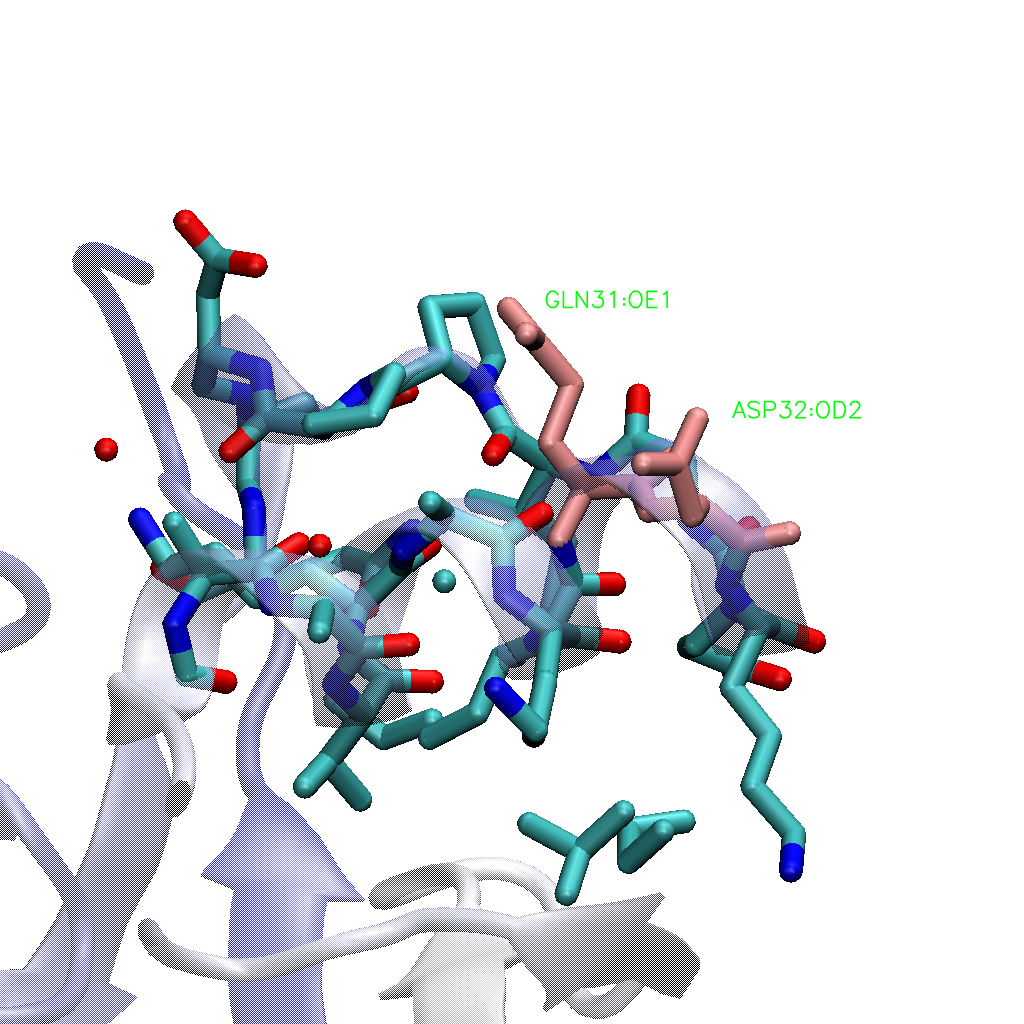

In [73]:
img1 = Image.open(f'{outdir}/acf3131_1190.png') # in
img2 = Image.open(f'{outdir}/acf3131_7005.png') # popped out

display(img1)

and then! when we see it popped out (its remarkable here that the psi angles stay the same even though it underwent this big conformation change??)

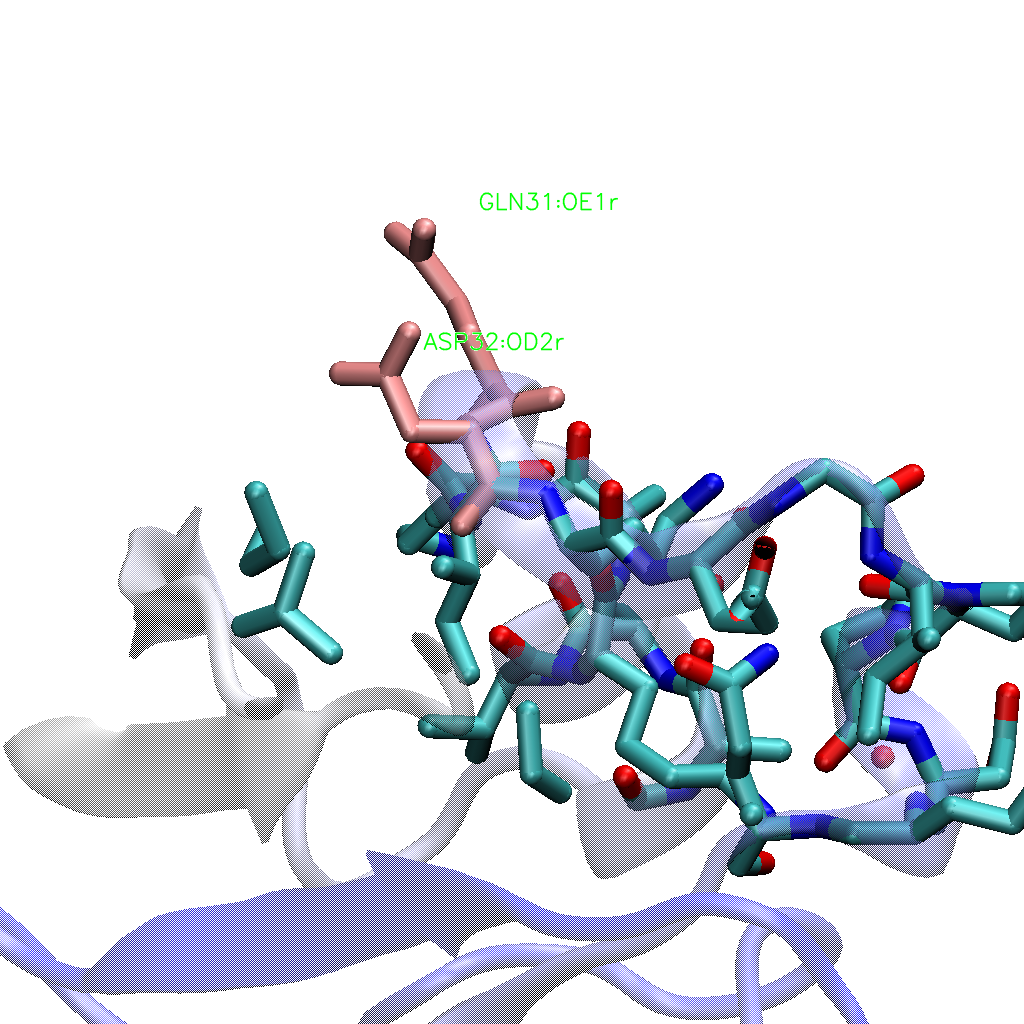

In [74]:
display(img2)

So we're considering the psi angles for these two residues, or the angle between C' and CA of the residue... Both of these residues are located in the part of the helix that actually pops out around 0.65/0.75 ms, so I feel like it would be strange for the two of them to stay autocorrelated even through that pop out. But, the psi angle for GLN31 is between it and ASP32, and the psi angle for ASP32 is with the adjacent LYS33. I totally think this is because they are locked in this helix in the beginning? so the psi angles don't fluctuate as much. But then, when it's popped out, the residues really don't make any contacts, but maintain their psi angles. that's insane!

Text(0.5, 1.0, 'Autocorr for ASN60')

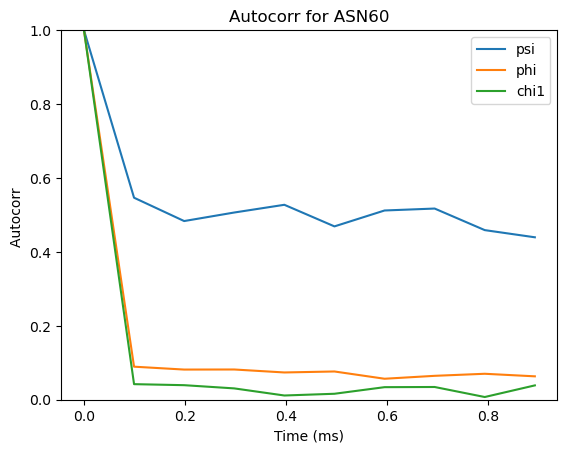

In [133]:
acf_psi = autocorr1(dihedral_dict['psi'][59],range(10))
acf_phi = autocorr1(dihedral_dict['phi'][59],range(10))
acf_chi1 = autocorr1(dihedral_dict['chi1'][59],range(10))

plt.plot(time[range(10)], acf_psi, label='psi')
plt.plot(time[range(10)], acf_phi, label='phi')
plt.plot(time[range(10)], acf_chi1, label='chi1')
plt.legend()
plt.ylabel(f'Autocorr ')
plt.ylim(0, 1)
plt.xlabel('Time (ms)')
plt.title(f"Autocorr for {sequence[59]}")

### Dual contacts ###

for residue 2: we have a very fast decay, its protruding out there, rapid decorrelation 

for residue 20: we see a slower decorrelation of the phi angle... (paul is not sure why)

In [15]:
import itertools
def product(x:np.ndarray, y:np.ndarray):
    return np.asarray(list(itertools.product(x, y)))


def combinations(x):
    return np.asarray(list(itertools.combinations(x, 2)))

def residue_distances(traj,
                      index_0: np.ndarray,
                      index_1: np.ndarray = None, dist=False):
    """ Brand new distance matrix. the inter case returns a compressed contact probability matrix, 
    but if idx=True, then it will return the whole distance matrix for ya :) """
    # intra distance case
    if index_1 is None:
        indices = combinations(index_0)
        return md.compute_contacts(traj, indices)[0], indices

    # inter distance case
    else:
        indices = product(index_0, index_1)
        if dist == True: 
            return md.compute_contacts(traj, indices)[0]
        else: 
            dist = md.compute_contacts(traj, indices)[0]
            return np.where(dist>.5, 0, 1)
        
def to_distance_matrix(distances: np.ndarray,
                       n: int,
                       m: int = None,
                       d0: int = 1):
    assert (distances.ndim == 2), "Must input a flattened distance array (n,d)"

    # info about flattened distance matrix
    N, d = distances.shape

    # intra molecular distances
    if m is None:
        matrix = np.zeros([N] + [n] * 2)
        i, j = np.triu_indices(n, d0)
        matrix[:, i, j] = distances
        return matrix + matrix.transpose(0, 2, 1)

    else:
        assert d == n * m, \
            "Given dimensions (n,m) do not correspond to the dimension of the flattened distances"

        return distances.reshape(-1, n, m)

In [8]:
dist, idx = residue_distances(trj, np.arange(76))

In [9]:
dist.shape

(10088, 2850)

In [16]:
fixed_dist = to_distance_matrix(dist, 76)

In [17]:
fixed_dist.shape

(10088, 76, 76)

In [18]:
# Let's fucking save this bc ain't no way in hell i'm computing that again 
np.save(f'{outdir}/intra_dist.npy', fixed_dist)

In [62]:
dist = np.load(f'{outdir}/intra_dist.npy')

In [63]:
dist.shape

(10088, 76, 76)

In [34]:
# creating a frame index for frames from 650 - 750 microseconds
pop_out_idx = np.arange(int(n_frames*0.65), int(n_frames*0.75))
pre_pop_idx = np.arange(0 , int(n_frames*0.5))

Text(0.5, 1.0, 'Dual Contact Probability from 650-750 microseconds')

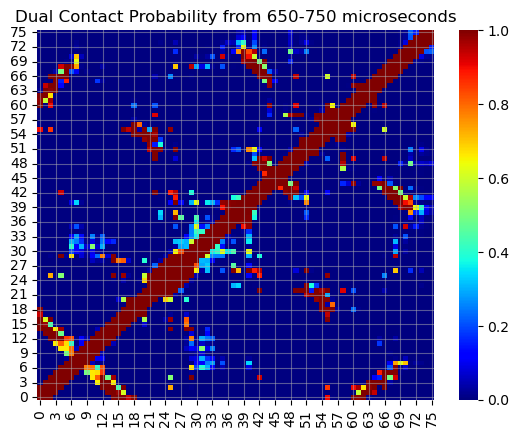

In [33]:
ax = sns.heatmap(np.where(dist<0.5, 1, 0)[pop_out_idx].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_title('Dual Contact Probability from 650-750 microseconds')
# for the whole thing 

Text(0.5, 1.0, 'Dual Contact Probability from 0-500 microseconds')

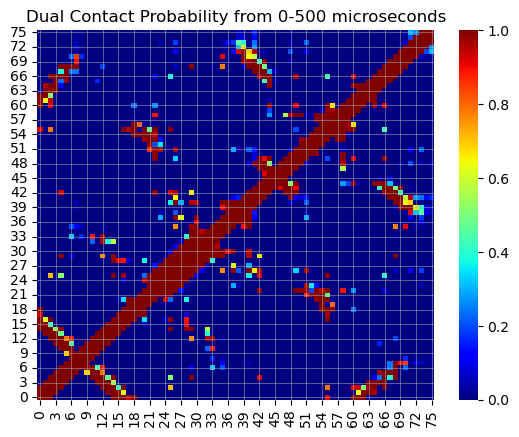

In [35]:
ax = sns.heatmap(np.where(dist<0.5, 1, 0)[pre_pop_idx].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_title('Dual Contact Probability from 0-500 microseconds')
# for the whole thing 

So there are some hotspots being formed when we are in the extended helical structure from 650-750 microseconds! I see changes for residues 30-36 and 9-12. 

### More HW prompts ###

Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

DONE

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

DONE

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 

  DONE
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 
  
  DONE

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

DONE

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

contact maps DONE hbonds DONE

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

hbond DONE 

7) Compute and visualize all-to-all RMSD calculation of the frames of this trajectory.  
 
DONE

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)

ATTEMPTED [but lowkey failed :( ]


9) Visualize the most populated clusters from your clustering analysis

Here is the equation used to calculate circular correlation coefficients for dihedral angles

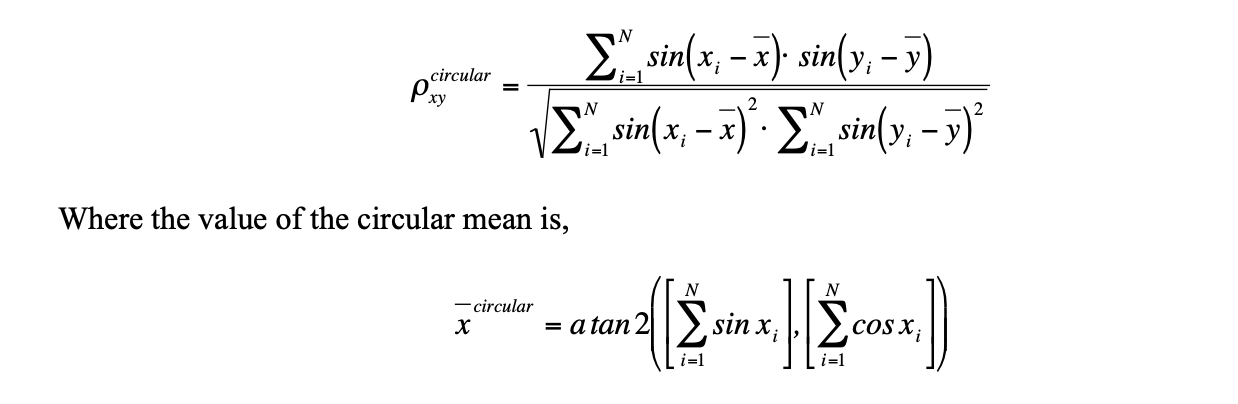


### Circular Correlation ###

In [134]:
def circular_mean(angle):
    # the definition of a circular mean
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    # finding the circular correlation between two angles, using the circular mean 
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [137]:
dihedral_dict['phi'].keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

In [160]:
# unfortunately doing this in a list comprehension way bc idk how else to do it :(
# doing this in the style of a dual contact map (n_res by n_res)
# where we populate each cell with the correlation between two residues psi and phi circular correlation across all trajectory frames
correlation_maps = []
for i in range(2, trj.n_residues-1): # have to cut some off that dont have psi/phi angles
    cor_map = []
    for j in range(2, trj.n_residues-1):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)

In [161]:
final_cor_map.shape

(73, 73)

<Axes: >

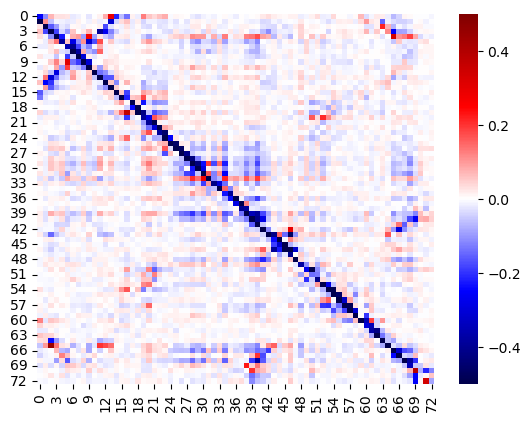

In [162]:
# so this is really hard to see! hence why paul has done it with a cool masking thing so we can see it better. 
sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5, cmap='seismic')

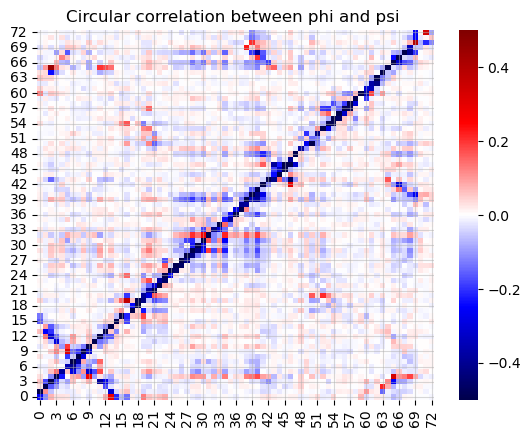

In [153]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
# ax.set_xticks(range(2, trj.n_residues-1))
# ax.set_yticks(range(2, trj.n_residues-1))
# ax.set_xticklabels(np.array(sequence)[2:trj.n_residues-1],rotation=45)
# ax.set_yticklabels(np.array(sequence)[2:trj.n_residues-1],rotation=45)
plt.title("Circular correlation between phi and psi ")
plt.show()

Lets calculate some correlations between dihedrals found in the paper: 


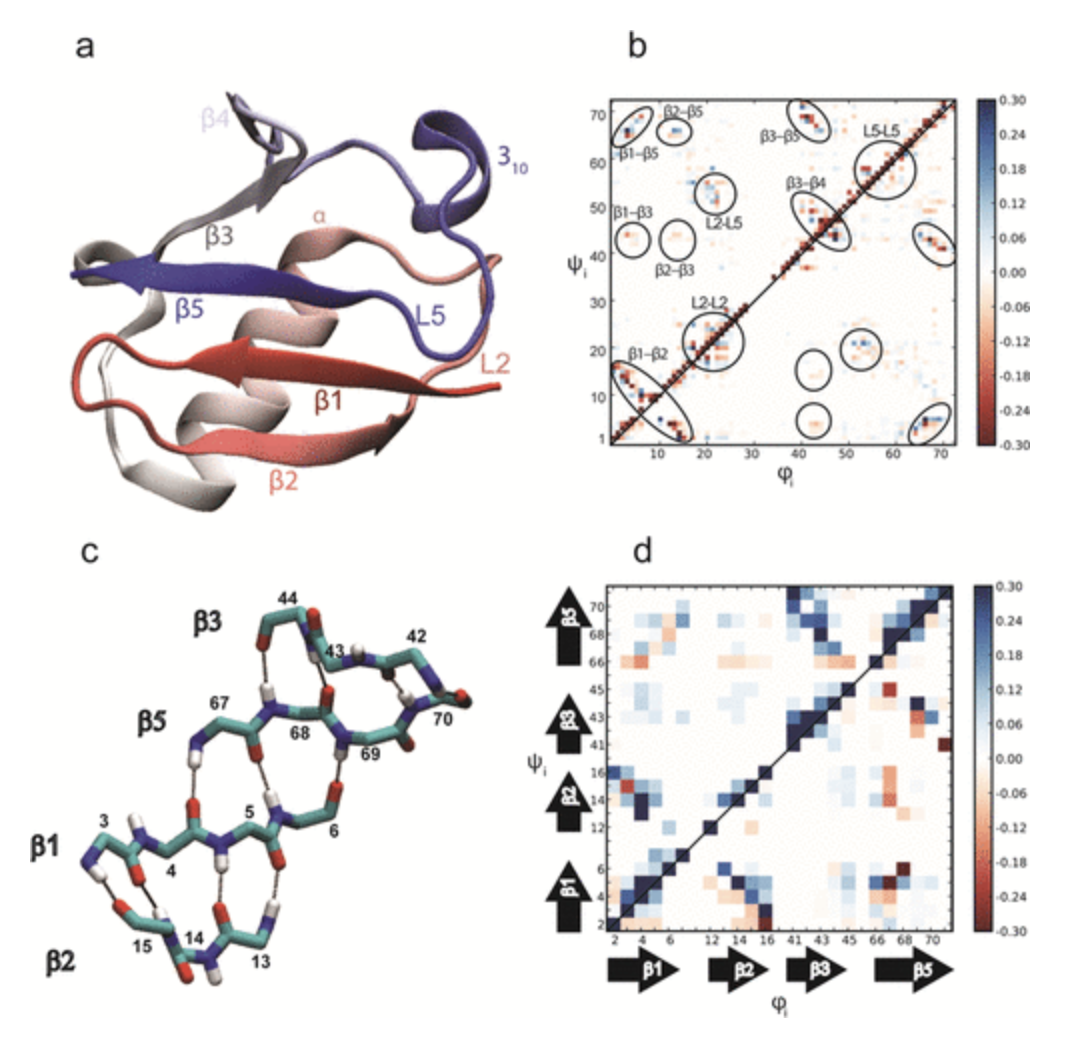

### Tentatively... trying clustering w what mdtraj was saying. ###
aka all-to-all RMSD

In [61]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform

In [64]:
trj

<mdtraj.Trajectory with 10088 frames, 1231 atoms, 76 residues, and unitcells at 0x10a67eed0>

In [66]:
distances = np.empty((trj.n_frames, trj.n_frames))
for i in range(trj.n_frames):
    distances[i] = md.rmsd(trj, trj, i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 0.679591 nm


In [69]:
np.save(f'{outdir}/frame-wise_RMSD.npy', distances)

In [4]:
distances = np.load(f'{outdir}/frame-wise_RMSD.npy')

In [5]:
# Clustering only accepts reduced form. Squareform's checks are too stringent
assert np.all(distances - distances.T < 1e-6)

AssertionError: 

In [6]:
# Damn! It failed the assertion. Well, let's still try to go ahead to see what's up: 
reduced_distances = squareform(distances, checks=False)
# this just reshapes this matrix to make the thing more happy for us

In [7]:
# Now, using this cute linkage function to cluster... 
linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')

In [8]:
# So it seems like we have this metric for every frame.... Let's investigate to see what this is
linkage.shape

(10087, 4)

In [11]:
# for the 0th frame
linkage[0]

array([3.19000000e+02, 1.45700000e+03, 1.29967362e-01, 2.00000000e+00])

In [10]:
# For the 6800th frame (structural bump)
linkage[6800]

array([70.        , 92.        ,  0.19129798,  2.        ])

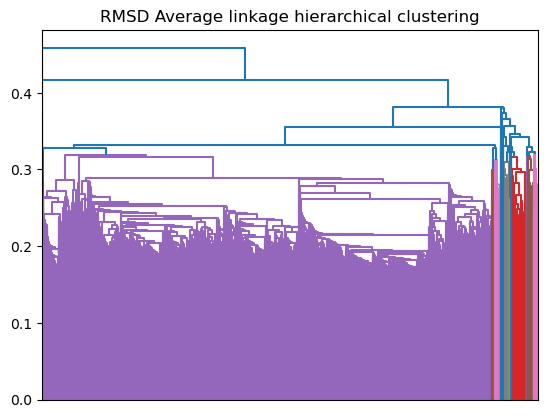

In [80]:
plt.title('RMSD Average linkage hierarchical clustering')
_ = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')
# plt.xlabel('frames')
# plt.xlim(6500, 10087)

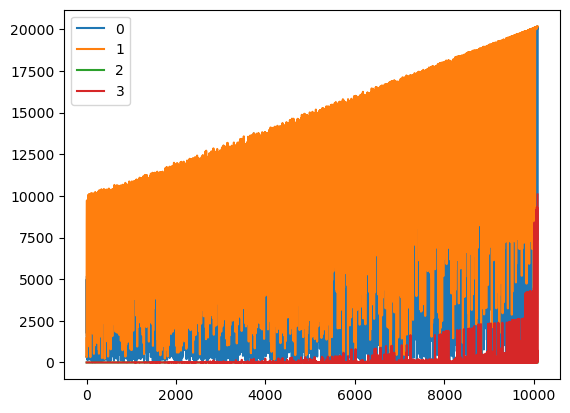

In [14]:
# this plot doesn't really make sense... let's see whats going on for each of these elements: 
for i in range(linkage.shape[1]): 
    plt.plot(linkage[:, i], label=i)
plt.legend()
